### Import libraries

In [19]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent, show
import earthpy as et
import earthpy.plot as ep
import numpy as np
import ogr
from skimage import exposure
from skimage.segmentation import quickshift, slic
from osgeo import gdal
import time
from osgeo import gdal
import cv2
import scipy

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import mahotas as mh
import networkx as nx
import pandas as pd
import plotly.express as px
import rioxarray as rxr
import xarray as xr
import time

from matplotlib import rcParams
from scipy import stats
from skimage import graph
from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import binary_dilation
from skimage.segmentation import mark_boundaries, slic
from skimage.util import map_array



In [3]:
driverTiff = gdal.GetDriverByName('GTiff')

### Import satellite imagery

In [4]:
# Path to the satellite image file
sat_clipped = "Data/imagery_subset_cliped.tif"
dsm_clipped = "Data/DSM_cliped.tif"

In [5]:
sat_src = rio.open(sat_clipped)

r = sat_src.read(1)
g = sat_src.read(2)
b = sat_src.read(3)
nir = sat_src.read(4)

dsm_src = rio.open(dsm_clipped)
dsm = dsm_src.read(1)



In [6]:
# Path to the satellite image file
sat_clipped = "Data/imagery_subset_cliped.tif"
dsm_clipped = "Data/DSM_cliped.tif"
sat_src = rio.open(sat_clipped)

# Read the bands from the satellite image
r = sat_src.read(1)
g = sat_src.read(2)
b = sat_src.read(3)
nir = sat_src.read(4)

# Read the DSM (Digital Surface Model)
dsm_src = rio.open(dsm_clipped)
dsm = dsm_src.read(1)

# Stack all the bands and the DSM into a single array
stacked = np.stack([r, g, b, nir, dsm], axis=-1)



In [8]:

# extract arrays
rgb = stacked.astype(np.uint8)[...,[0,1,2]]

#CALCULAR NDVI
ndvi = (stacked[...,3] - stacked[...,0])/(stacked[...,3] + stacked[...,0])


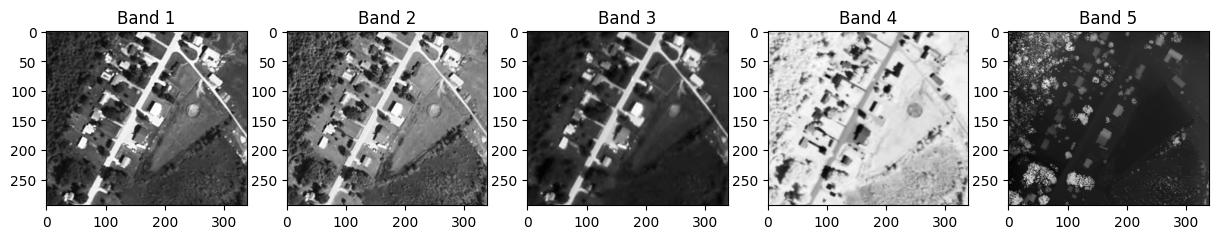

In [9]:

# Visualize each band separately
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed

# Plot each band
for i in range(stacked.shape[-1]):
    plt.subplot(1, stacked.shape[-1], i + 1)
    plt.imshow(stacked[:, :, i], cmap='gray')
    plt.title(f'Band {i+1}')

plt.show()


In [10]:
# scale image values from 0.0 - 1.0
#img = exposure.rescale_intensity(stacked)

# do segmentation multiple options with quickshift
seg_start = time.time()

#PARAMETERS:
#ratio: higher value for ratio allows more weight on the color similarity, while a lower value gives more importance to the spatial proximity
#max_dist: scale

segments = quickshift(stacked, ratio=0.2, max_dist=6.5, convert2lab=False)


print('segments complete', time.time() - seg_start)

# save segments to raster
segments_fn = 'Outputs/segments.tif'
segments_ds = driverTiff.Create(segments_fn, sat_src.width, sat_src.height, 1, gdal.GDT_Float32)
geotransform = sat_src.transform.to_gdal()
segments_ds.SetGeoTransform(geotransform)
segments_ds.SetProjection(sat_src.crs.wkt)
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

segments complete 1.8386495113372803


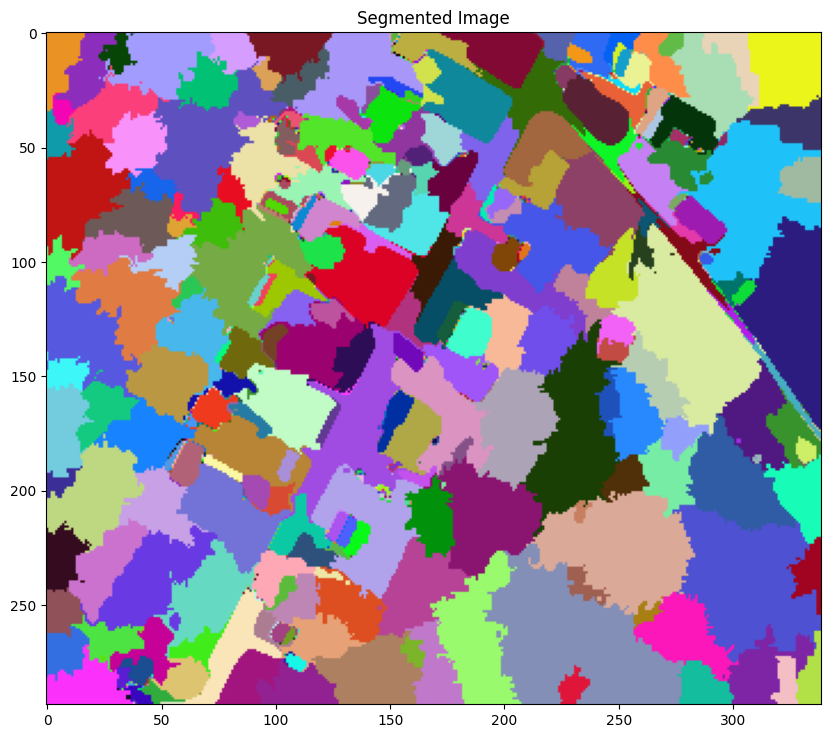

In [11]:
# Read the segmented image
with rio.open(segments_fn) as src:
    segments = src.read(1)

# Get the unique segment IDs
unique_segments = np.unique(segments)

# Create a random colormap for visualization
np.random.seed(42)  # For reproducibility of colors
colors = np.random.randint(0, 255, size=(len(unique_segments), 3), dtype=np.uint8)

# Create a colormap dictionary mapping segment IDs to colors
colormap = {segment_id: color for segment_id, color in zip(unique_segments, colors)}

# Map the segment IDs to the colormap to get the colored segmented image
colored_segments = np.array([colormap[segment_id] for segment_id in segments.flat]).reshape(segments.shape + (3,))

# Display the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(colored_segments)
plt.title('Segmented Image')
plt.show()

In [109]:
"""def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            # in this case the variance = nan, change it 0.0
            band_stats[3] = 0.0
        features += band_stats
    return features"""

In [110]:
"""segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = stacked[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)"""

C:\Users\cande\AppData\Local\Temp\ipykernel_10144\4147965427.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats = scipy.stats.describe(segment_pixels[:, b])
c:\Users\cande\anaconda3\envs\spatialenv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\cande\anaconda3\envs\spatialenv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\cande\anaconda3\envs\spatialenv\lib\site-packages\scipy\stats\_stats_py.py:1522: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis,

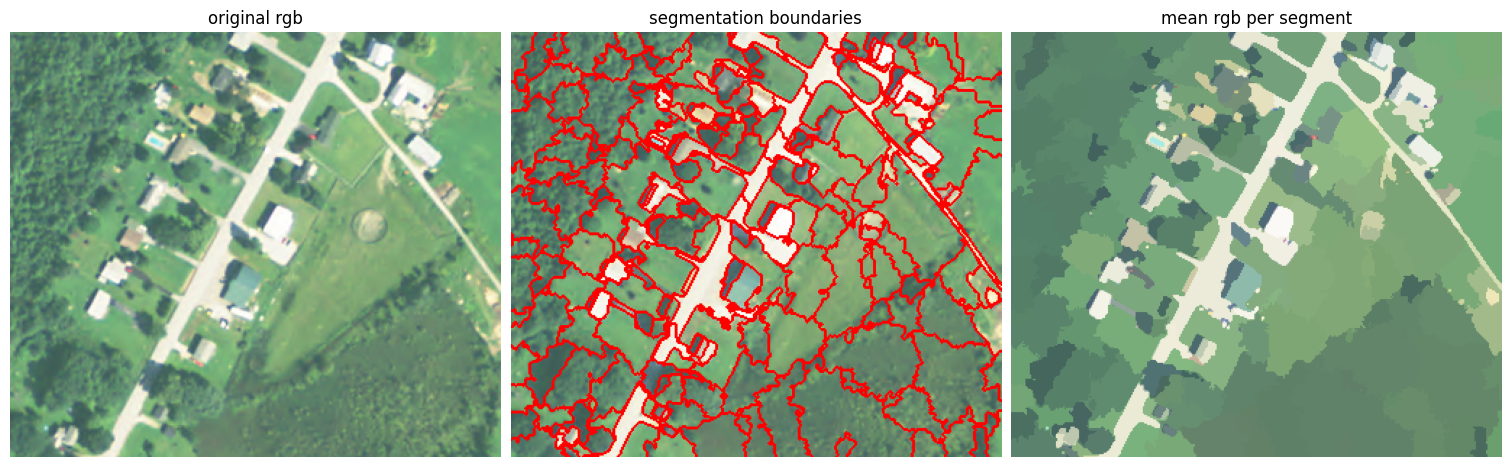

In [12]:
# visualise rgb & segmentation
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Show the RGB image
axs[0].imshow(rgb)
axs[1].imshow(mark_boundaries(rgb, segments, (1, 0, 0), mode="thick"))
axs[2].imshow(label2rgb(segments, rgb, kind='avg').astype(int))

axs[0].set_title("original rgb")
axs[1].set_title("segmentation boundaries")
axs[2].set_title("mean rgb per segment")

for ax in axs:
    ax.set_axis_off()

plt.show()

In [14]:
# Convert the segments array to integer data type
segments = segments.astype(int)

# define mean calculation function
def calc_mean(seg_arr, img_arr):
    spec_feats = regionprops_table(
        label_image = seg_arr, 
        intensity_image = img_arr,
        properties = ["label", "intensity_mean"]
        )
    return pd.DataFrame(spec_feats)  

# perform calculation & get timing
means = calc_mean(segments, np.dstack([rgb, ndvi]))
display(means)

,label,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3
0,1,69.363640,99.181816,114.272728,0.050855
1,2,121.000000,149.500000,154.000000,-0.190444
2,3,73.009010,104.288292,105.621620,-0.044262
3,4,163.333328,186.000000,183.333328,-0.285077
4,5,114.305313,156.438049,120.154869,0.246520
...,...,...,...,...,...
633,634,186.000000,208.000000,185.000000,0.038760
634,635,158.800003,191.000000,144.199997,0.075577
635,636,70.500000,107.500000,103.000000,0.208187
636,637,73.000000,111.000000,103.000000,0.353982


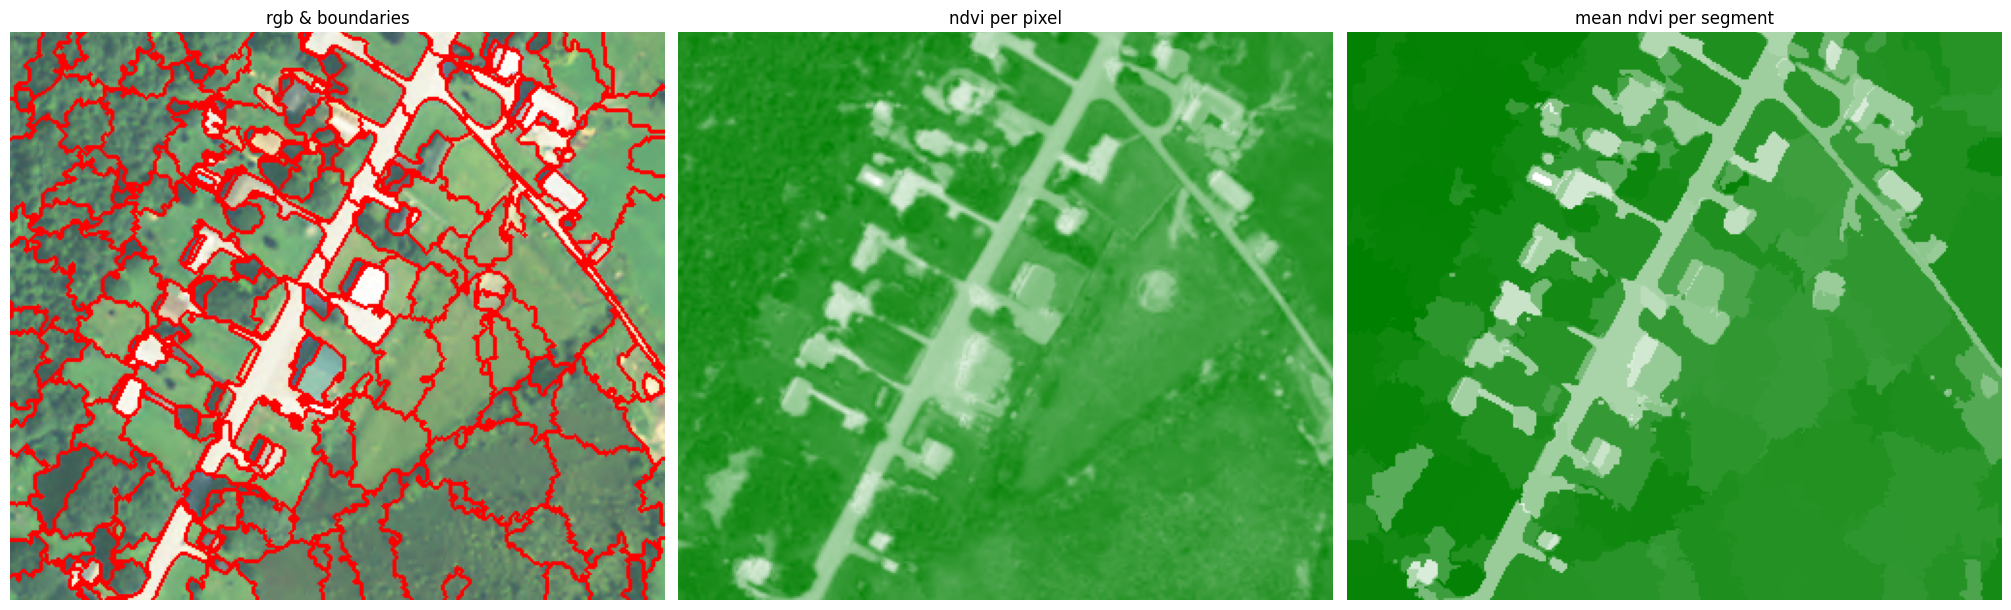

In [23]:
# mapping NDVI vals back to image segments
mapped_mean = map_array(
    segments, 
    np.array(means["label"]), 
    np.array(means["intensity_mean-3"])
    )


# Define the custom colormap with green for high NDVI values and grey for low NDVI values
colors = [(0.0, 'white'), (1.0, 'green')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# visualise
fig, axs = plt.subplots(ncols=3, figsize=(20,10), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb, segments, (1,0,0), mode="thick"))
axs[1].imshow(ndvi, cmap=custom_cmap)
axs[2].imshow(mapped_mean, cmap=custom_cmap)  # Use the custom colormap here

axs[0].set_title("rgb & boundaries")
axs[1].set_title("ndvi per pixel")
axs[2].set_title("mean ndvi per segment")

for ax in axs.flat:
    ax.set_axis_off()

plt.show()